In [1]:
# import cell
import typing as t

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as rq
import seaborn as sns

from sklearn.linear_model import LinearRegression

import utils

In [2]:
# 1) Obtain the DAILY amount of rain in inch
# (called Rain Sum) from 09/01/2023 to 10/30/2023 in Boston and record that in a list, "rain".
# You should obtain the data using API.
# DO NOT directly download as ".XLSX" or ".CSV". (10 pts.)

# Website: https://open-meteo.com/en/docs/historical-weather-api
# Hint: You will deal with the API and it looks like this in your code:
# "https://api.open-meteo.com/v1/forecast?latitude=42.3584&longitude=-71.0598&daily=rain_sum  . . ."


def get_weather_df(
    base_url: str = "https://archive-api.open-meteo.com/v1/archive",
    col_as_time_index: str = "time",
    **params: t.Any,
) -> pd.DataFrame:
    """
    gets weather dataframe from `https://archive-api.open-meteo.com/v1/archive`

    args:
        - base_url (str): url
        - col_as_time_index: str or None: if this column exists, it will become a pd.DateTimeIndex
        - **params: passed to the url and joined with '&', can override default params.
    returns:
        - DataFrame
    """
    if base_url.endswith("/"):
        base_url.removesuffix("/")
    if not base_url.endswith("?"):
        base_url += "?"
    if not (hourly := params.get("hourly")) and not params.get("daily"):
        raise ValueError("you must provide this value")
    _params = {
        "latitude": 42.3584,
        "longitude": -71.0598,
        "start_date": "2023-09-01",
        "end_date": "2023-10-30",
        "timezone": r"America%2FNew_York",
        "precipitation_unit": "inch",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
    } | params
    rain_resp = rq.get(
        base_url + "&".join(f"{k}={v}" for k, v in _params.items()), timeout=10
    )
    rain_resp.raise_for_status()

    _dataframe = pd.DataFrame.from_dict(
        rain_resp.json()["hourly" if hourly else "daily"]
    )
    if col_as_time_index in _dataframe.columns:
        _dataframe.set_index(
            pd.to_datetime(_dataframe[col_as_time_index], format="ISO8601"),
            inplace=True,
        )
        _dataframe.drop(inplace=True, columns=[col_as_time_index])
        _dataframe.index.name = None
    return _dataframe


rain_df = get_weather_df(daily="rain_sum")
rain_df.head()

,rain_sum
2023-09-01,0.000
2023-09-02,0.000
2023-09-03,0.004
2023-09-04,0.000
2023-09-05,0.008


In [3]:
# 2) Label the days with 0 rain as sunny and the days with any rain amount of  > 0 as rainy by creating one categorical column. You then need to convert this categorical column to two binary columns. (10 pts.

# the following code uses the method we used in lab 1 but what I have is the exact same but faster

# rain_df_cats = pd.DataFrame()
# # this should be inplace, but whatever
# rain_df_cats[""] = (
#     rain_df["rain_sum"].apply(lambda x: "rainy" if x else "sunny").astype("category")
# )
# rain_df_cats = pd.get_dummies(rain_df_cats, columns=[""], prefix_sep="", dtype=int)

rain_df_cats = pd.get_dummies(
    rain_df["rain_sum"].apply(lambda x: "rainy" if x else "sunny").astype("category"),
    # columns=[""],
    prefix_sep="",
    dtype=int,
)

rain_df_cats.head()

,rainy,sunny
2023-09-01,0,1
2023-09-02,0,1
2023-09-03,1,0
2023-09-04,0,1
2023-09-05,1,0


<Axes: title={'center': 'inches of rain boxplot (outliers removed)'}, xlabel='rain sum over 60 days', ylabel='inches of rain'>

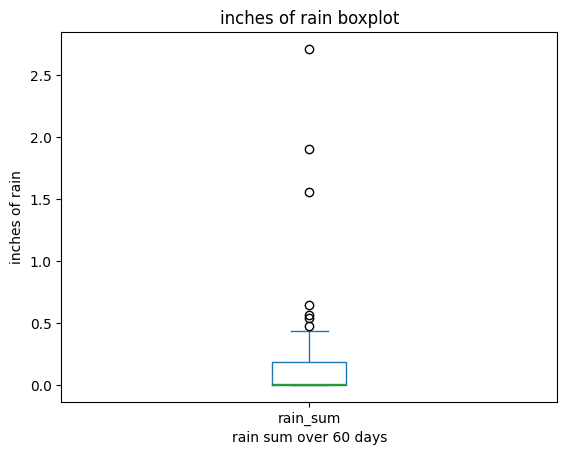

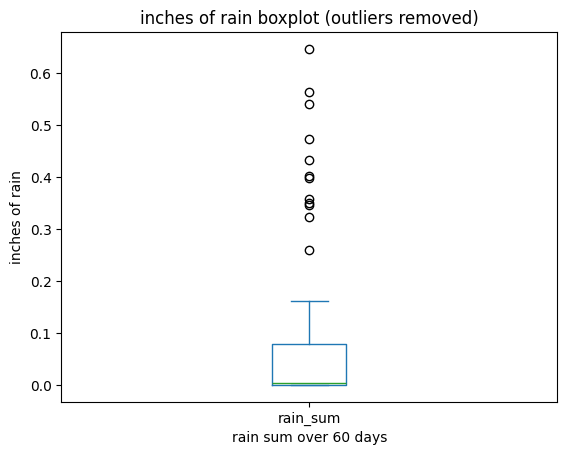

In [4]:
# 3) Draw a boxplot (with appropriate x and y labels and title) to see how the data looks like. If the boxplot looks very compressed, you need to manually make adjustments to remove very few outliers so that the boxplot is of natural shape. (20 pts.)

rain_df.plot(
    column="rain_sum",
    kind="box",
    xlabel="rain sum over 60 days",
    title="inches of rain boxplot",
    ylabel="inches of rain",
    # yticks=[5],
)

rain_df.loc[rain_df["rain_sum"] < 1.5].plot(
    column="rain_sum",
    kind="box",
    xlabel="rain sum over 60 days",
    title="inches of rain boxplot (outliers removed)",
    ylabel="inches of rain",
    # yticks=[5],
)

# ax_boxplot.set_yticks([5])

In [5]:
# 4) Acquire the following five predictors:
# (a) Maximum Temperature (2m) (in Fahrenheit),
# (b) Minimum Temperature (in Fahrenheit),
# (c) Mean Temperature (2m) (in Fahrenheit),
# (d) Short Radiation Sum (in Megajoules),
# (e) Maximum Wind Speed (10 m) (in mph).
# You already acquired "Rain Sum (in inch)" in section 1 of this question and now should consider it as your target value.
# Create a data frame and print the output. (20 pts.)

# due to the nature of this problem, it kinda asks for
# separate api calls, but in real life, it's better to do one (the api lets you lump all this data together)

daily_params = {
    "temperature_2m_max": [75.7],
    "apparent_temperature_min": [63.4],
    "temperature_2m_mean": [66],
    "shortwave_radiation_sum": [16.1],
    "wind_speed_10m_max": [15.9],
}
# units are specified within `get_weather_df`

# Q: do we keep the boolean columns...?

temp_df = get_weather_df(daily=",".join(daily_params)).merge(
    rain_df["rain_sum"], how="inner", right_index=True, left_index=True
)  # you could also add it to the "daily_params" tuple, but this saves transfer data lol
temp_df.head()

,temperature_2m_max,apparent_temperature_min,temperature_2m_mean,shortwave_radiation_sum,wind_speed_10m_max,rain_sum
2023-09-01,72.3,50.5,62.9,23.40,8.2,0.000
2023-09-02,80.0,53.4,66.8,22.17,11.2,0.000
2023-09-03,84.9,63.1,73.6,20.84,9.4,0.004
2023-09-04,85.4,68.5,73.5,21.16,10.0,0.000
2023-09-05,86.6,72.7,75.9,19.46,8.1,0.008


Text(0.5, 1.0, 'corralation and effect of weather conditions upon each other')

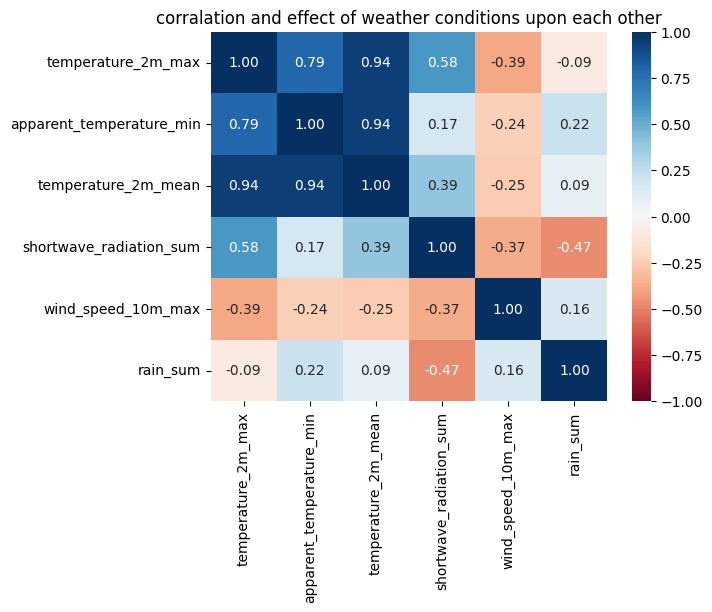

In [6]:
# 5) Show a heatmap with the five predictors and the target value.
# Parameters: colorbar= from dark red to dark blue, range= -1 to +1,
# correlation values shown on each cell rounded to 2 digits. (20 pts.)

# Q: is this even close to right?

corr = temp_df.corr()

ax_heatmap = sns.heatmap(
    corr,
    xticklabels=corr.columns.to_list(),  # mypy complains without `to_list()`
    yticklabels=corr.columns.to_list(),
    cmap="RdBu",
    vmin=-1,
    vmax=1,  # i don't think u need these
    annot=True,
    fmt=".2f",  # by default
    center=0,
)

ax_heatmap.set_title("corralation and effect of weather conditions upon each other")

In [7]:
# 6) Fit a linear regression model and print if the following day would be "rainy" or "sunny". (20 pts.)

# newDay({'Maximum Temperature=75.7', 'Minimum Temperature=63.4', 'Mean Temperature=66',  'Short Radiation Sum=16.1', 'Maximum Wind Speed=15.9'})

# pd.merge always fails, why...?
# utils.normalize_df is from the first homework

# daily_params = {
#     "temperature_2m_max": [75.7],
#     "apparent_temperature_min": [63.4],
#     "temperature_2m_mean": [66],
#     "shortwave_radiation_sum": [16.1],
#     "wind_speed_10m_max": [15.9],
# }

training = pd.concat(
    [
        utils.normalize_df(
            pd.concat([temp_df, pd.DataFrame.from_dict(daily_params, orient="columns")])
        ),
        rain_df_cats,
    ],
    join="outer",
    axis=1,
)

outcomes = ["sunny", "rainy"]
predictors = [
    col for col in training.columns if col not in outcomes and col in daily_params
]

# the last row is our prediction, so we pull it out
model = LinearRegression()
model.fit(training[predictors].iloc[:-1], training[outcomes].iloc[:-1])
prediction = model.predict(training[predictors].iloc[-1].to_frame().T)
for out, pred in zip(outcomes, prediction[0]):
    print(f"{out}: {pred}")

sunny: 0.2709618755391261
rainy: 0.7290381244608739


This means that there's a 72.9% chance of rain when these conditions are present:

```python
daily_params = {
    "temperature_2m_max": [75.7],
    "apparent_temperature_min": [63.4],
    "temperature_2m_mean": [66],
    "shortwave_radiation_sum": [16.1],
    "wind_speed_10m_max": [15.9],
}
```

the chance of rain is higher than it is to be sunny.